### Import data - all sessions

518 TRs x 630 parcels

In [9]:
%load_ext autoreload
%autoreload 2
%pylab nbagg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/Users/rafi/miniconda/envs/dyno/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['partition', 'norm', 'size']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dyneusr as dy
from umap.umap_ import UMAP
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from kmapper import KeplerMapper, Cover
from hdbscan import HDBSCAN
from load_data import load_scrubbed

sessions = load_scrubbed(n_sessions=-1, merge=False)

/Users/rafi/miniconda/envs/dyno/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/rafi/miniconda/envs/dyno/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/rafi/Documents/Stanford/Saggar_Lab/dyneusr/dyneusr/__init__.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/rafi/miniconda/envs/dyno/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/rafi/miniconda/envs/dyno/lib/python3.6/runpy.py", line 85, in

INFO:root:  [+] session: 38, path: data/base/combined_data_scrubbed/sub056.txt
INFO:root:  [+] session: 39, path: data/base/combined_data_scrubbed/sub057.txt
INFO:root:  [+] session: 40, path: data/base/combined_data_scrubbed/sub058.txt
INFO:root:  [+] session: 41, path: data/base/combined_data_scrubbed/sub059.txt
INFO:root:  [+] session: 42, path: data/base/combined_data_scrubbed/sub060.txt
INFO:root:  [+] session: 43, path: data/base/combined_data_scrubbed/sub061.txt
INFO:root:  [+] session: 44, path: data/base/combined_data_scrubbed/sub062.txt
INFO:root:  [+] session: 45, path: data/base/combined_data_scrubbed/sub063.txt
INFO:root:  [+] session: 46, path: data/base/combined_data_scrubbed/sub064.txt
INFO:root:  [+] session: 47, path: data/base/combined_data_scrubbed/sub065.txt
INFO:root:  [+] session: 48, path: data/base/combined_data_scrubbed/sub066.txt
INFO:root:  [+] session: 49, path: data/base/combined_data_scrubbed/sub067.txt
INFO:root:  [+] session: 50, path: data/base/combine

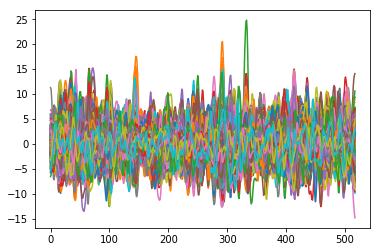

In [75]:
from scipy.stats import zscore
Xz = zscore(sessions[70].X,axis=0)
plt.close('all')
plt.plot(sessions[70].X)
plt.show()

### Import resting state network parcellation labels

In [87]:
df_parcel = pd.read_table('data/base/parcellation/parcel_data.txt',header=None)
rsn = pd.factorize(df_parcel.iloc[:,7])

dmn = df_parcel.index[df_parcel[7] == 'DMN'].tolist()
dan = df_parcel.index[df_parcel[7] == 'Dorsal_Attention'].tolist()
van = df_parcel.index[df_parcel[7] == 'Ventral_Attention'].tolist()
fp1 = df_parcel.index[df_parcel[7] == 'Frontoparietal_1'].tolist()
cing = df_parcel.index[df_parcel[7] == 'Cingulo_opercular'].tolist()
sal = df_parcel.index[df_parcel[7] == 'Salience'].tolist()
som = df_parcel.index[df_parcel[7] == 'Somatomotor'].tolist()
v2 = df_parcel.index[df_parcel[7] == 'Visual_2'].tolist()
medpar = df_parcel.index[df_parcel[7] == 'Medial_Parietal'].tolist()
parocc = df_parcel.index[df_parcel[7] == 'Parieto_occipital'].tolist()
fp2 = df_parcel.index[df_parcel[7] == 'Frontoparietal 2'].tolist()
v1 = df_parcel.index[df_parcel[7] == 'Visual_1'].tolist()

/Users/rafi/miniconda/envs/dyno/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rafi/miniconda/envs/dyno/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/rafi/miniconda/envs/dyno/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


array([<matplotlib.axes._subplots.AxesSubplot object at 0x14ef96898>,
      dtype=object)

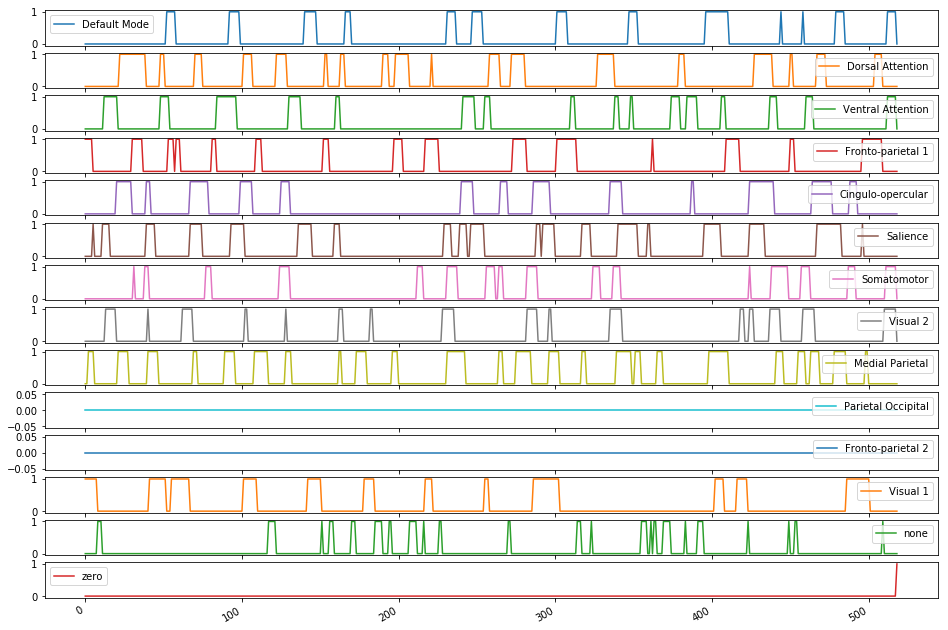

In [76]:
rsn_act = np.zeros((Xz.shape[0]+1,14))
thres = 0.5
for tr,t in enumerate(Xz):
    # Get average RSN activity of five networks
    activity = np.array([np.mean(t[dmn]),
                         np.mean(t[dan]), 
                         np.mean(t[van]), 
                         np.mean(t[fp1]), 
                         np.mean(t[cing]), 
                         np.mean(t[sal]),
                         np.mean(t[som]),
                         np.mean(t[v2]),
                         np.mean(t[medpar]),
                         np.mean(t[parocc]),
                         np.mean(t[fp2]),
                         np.mean(t[v1])])
    # Set those columns to true
    activation = np.argwhere(activity>thres).flatten()
    if activation.size != 0:
        rsn_act[tr,activation] = 1
    else:
        rsn_act[tr,12] = 1
        
# Add a zero centroid where all ROIs are 0 z-score
rsn_act[-1,13] = 1
# Add a TR that's at mean signal / 0 z-score, where does it localize on the graph?
Xz = np.vstack((Xz,np.zeros((630,))))
        
df_rsn = pd.DataFrame(rsn_act,columns=['Default Mode',
                                       'Dorsal Attention',
                                       'Ventral Attention',
                                       'Fronto-parietal 1',
                                       'Cingulo-opercular',
                                       'Salience',
                                       'Somatomotor',
                                       'Visual 2',
                                       'Medial Parietal',
                                       'Parietal Occipital',
                                       'Fronto-parietal 2',
                                       'Visual 1',
                                       'none',
                                       'zero'])
df_rsn.plot(subplots=True,figsize=(16,12))

### Create a test mapper for a session to optimize resolution and gain

In [77]:
mapper = KeplerMapper(verbose=1)
lens = mapper.fit_transform(Xz, projection=TSNE(random_state=420))

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=420, verbose=0)
	Distance matrices: False
	Scalers: MinMaxScaler(copy=True, feature_range=(0, 1))
..Projecting on data shaped (519, 630)

..Projecting data using: 
	TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=420, verbose=1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 519 samples in 0.007s...
[t-SNE] Computed neighbors for 519 samples in 0.346s...
[t-SNE] Computed conditional probabilities for sample 519 / 519
[t-SNE] Mean sigma: 11.888751
[t-SNE] KL divergence after 250 iterati

In [78]:
graph = mapper.map(lens, Xz, clusterer=HDBSCAN(allow_single_cluster=True), cover=Cover(10,0.67))

Mapping on data shaped (519, 630) using lens shaped (519, 2)

Creating 100 hypercubes.

Created 156 edges and 81 nodes in 0:00:00.189269.


In [8]:
from pprint import pprint
labels = {_:[str(_)+' not active', str(_)+' is active'] for _ in df_rsn.columns}
pprint(labels)

{'Cingulo-opercular': ['Cingulo-opercular not active',
                       'Cingulo-opercular is active'],
 'Default Mode': ['Default Mode not active', 'Default Mode is active'],
 'Dorsal Attention': ['Dorsal Attention not active',
                      'Dorsal Attention is active'],
 'Fronto-parietal 1': ['Fronto-parietal 1 not active',
                       'Fronto-parietal 1 is active'],
 'Fronto-parietal 2': ['Fronto-parietal 2 not active',
                       'Fronto-parietal 2 is active'],
 'Medial Parietal': ['Medial Parietal not active', 'Medial Parietal is active'],
 'Parietal Occipital': ['Parietal Occipital not active',
                        'Parietal Occipital is active'],
 'Salience': ['Salience not active', 'Salience is active'],
 'Somatomotor': ['Somatomotor not active', 'Somatomotor is active'],
 'Ventral Attention': ['Ventral Attention not active',
                       'Ventral Attention is active'],
 'Visual 1': ['Visual 1 not active', 'Visual 1 is active']

In [79]:
# Fit DyNeuGraph
dyneuG = dy.DyNeuGraph()
dyneuG.fit(G=graph,y=df_rsn, labels=labels, rsn_color='separate')

Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 1 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 1 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: zero
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Processing 

DyNeuGraph()

In [80]:
dyneuG.visualize(path_html='test6.html', show=False, reset=True, static=False, PORT=8800)

[Force Graph] http://localhost:8800/test6.html


DyNeuGraph()

### Load all sessions of data and convert to Mapper graphs

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dyneusr as dy
from umap.umap_ import UMAP
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from kmapper import KeplerMapper, Cover
from hdbscan import HDBSCAN
from load_data import load_scrubbed
from scipy.stats import zscore

sessions = load_scrubbed(n_sessions=-1, merge=False)

df_parcel = pd.read_table('data/base/parcellation/parcel_data.txt',header=None)
rsn = pd.factorize(df_parcel.iloc[:,7])

dmn = df_parcel.index[df_parcel[7] == 'DMN'].tolist()
dan = df_parcel.index[df_parcel[7] == 'Dorsal_Attention'].tolist()
van = df_parcel.index[df_parcel[7] == 'Ventral_Attention'].tolist()
fp1 = df_parcel.index[df_parcel[7] == 'Frontoparietal_1'].tolist()
cing = df_parcel.index[df_parcel[7] == 'Cingulo_opercular'].tolist()
sal = df_parcel.index[df_parcel[7] == 'Salience'].tolist()
som = df_parcel.index[df_parcel[7] == 'Somatomotor'].tolist()
v2 = df_parcel.index[df_parcel[7] == 'Visual_2'].tolist()
medpar = df_parcel.index[df_parcel[7] == 'Medial_Parietal'].tolist()
parocc = df_parcel.index[df_parcel[7] == 'Parieto_occipital'].tolist()
fp2 = df_parcel.index[df_parcel[7] == 'Frontoparietal 2'].tolist()
v1 = df_parcel.index[df_parcel[7] == 'Visual_1'].tolist()

rsns = ['Default Mode',
       'Dorsal Attention',
       'Ventral Attention',
       'Fronto-parietal 1',
       'Cingulo-opercular',
       'Salience',
       'Somatomotor',
       'Visual 2',
       'Medial Parietal',
       'Parietal Occipital',
       'Fronto-parietal 2',
       'Visual 1',
       'none']

thres = 0.5

df_behavior = pd.read_table('data/base/behavior/trackingdata_goodscans.txt')

INFO:load_data:load_scrubbed(**{'n_sessions': -1, 'merge': False})
INFO:load_data:Loading data...
INFO:root:  [+] session: 1, path: data/base/combined_data_scrubbed/sub014.txt
INFO:root:  [+] session: 2, path: data/base/combined_data_scrubbed/sub015.txt
INFO:root:  [+] session: 3, path: data/base/combined_data_scrubbed/sub016.txt
INFO:root:  [+] session: 4, path: data/base/combined_data_scrubbed/sub017.txt
INFO:root:  [+] session: 5, path: data/base/combined_data_scrubbed/sub018.txt
INFO:root:  [+] session: 6, path: data/base/combined_data_scrubbed/sub019.txt
INFO:root:  [+] session: 7, path: data/base/combined_data_scrubbed/sub020.txt
INFO:root:  [+] session: 8, path: data/base/combined_data_scrubbed/sub021.txt
INFO:root:  [+] session: 9, path: data/base/combined_data_scrubbed/sub022.txt
INFO:root:  [+] session: 10, path: data/base/combined_data_scrubbed/sub023.txt
INFO:root:  [+] session: 11, path: data/base/combined_data_scrubbed/sub024.txt
INFO:root:  [+] session: 12, path: data/ba

In [40]:
dyneuGs = dict()
Gs = []
#for sess_num in [0,13,27,41,55,69,83]:
for sess_num,session in enumerate(sessions): # Go gung ho
    #if sess_num > 3 : continue
    print('Session %d...' % sess_num)
    # Zscore data
    Xz = zscore(session.X,axis=0)
    # Get RSN activations
    rsn_act = np.zeros((Xz.shape[0]+1,13))
    for tr,t in enumerate(Xz):
        # Get average RSN activity of each network
        activity = np.array([np.mean(t[dmn]),
                             np.mean(t[dan]), 
                             np.mean(t[van]), 
                             np.mean(t[fp1]), 
                             np.mean(t[cing]), 
                             np.mean(t[sal]),
                             np.mean(t[som]),
                             np.mean(t[v2]),
                             np.mean(t[medpar]),
                             np.mean(t[parocc]),
                             np.mean(t[fp2]),
                             np.mean(t[v1])])
        # Set those columns to true
        activation = np.argwhere(activity>thres).flatten()
        if activation.size != 0:
            rsn_act[tr,activation] = 1
        else:
            rsn_act[tr,12] = 1


    df_rsn = pd.DataFrame(rsn_act,columns=['Default Mode',
                                           'Dorsal Attention',
                                           'Ventral Attention',
                                           'Fronto-parietal 1',
                                           'Cingulo-opercular',
                                           'Salience',
                                           'Somatomotor',
                                           'Visual 2',
                                           'Medial Parietal',
                                           'Parietal Occipital',
                                           'Fronto-parietal 2',
                                           'Visual 1',
                                           'none'])
    labels = {_:[str(_)+' not active', str(_)+' is active'] for _ in df_rsn.columns}
    
    # Mapper and DyNeuSR
    mapper = KeplerMapper(verbose=0)
    lens = mapper.fit_transform(Xz, projection=TSNE(random_state=420))
    graph = mapper.map(lens, Xz, clusterer=HDBSCAN(allow_single_cluster=True), cover=Cover(10,0.67))
    # Fit DyNeuGraph
    sess_str = 'session' + str(sess_num+1)
    dyneuGs[sess_str] = dy.DyNeuGraph()
    dyneuGs[sess_str].fit(G=graph,y=df_rsn, labels=labels, rsn_color='separate')
    dyneuGs[sess_str].visualize(path_html='test%d.html' % (sess_num+1), show=False, reset=True, static=False, PORT=8800)
    Gs.append(dyneuGs[sess_str].G_)

Session 0...
Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Processing meta column: default
  [+] found 1 unique gro

Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Processing meta column: default
  [+] found 1 unique groups.
1.0
[For

Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Processing meta column: default
  [+] found 1 unique groups.
1.0
[For

Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Processing meta column: default
  [+] found 1 unique groups.
1.0
[For

Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Processing meta column: default
  [+] found 1 unique groups.
1.0
[For

Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Processing meta column: default
  [+] found 1 unique groups.
1.0
[For

Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Processing meta column: default
  [+] found 1 unique groups.
1.0
[For

Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Processing meta column: default
  [+] found 1 unique groups.
1.0
[For

Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Processing meta column: default
  [+] found 1 unique groups.
1.0
[For

Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Processing meta column: default
  [+] found 1 unique groups.
1.0
[For

Processing meta column: Default Mode
  [+] found 2 unique groups.
Processing meta column: Dorsal Attention
  [+] found 2 unique groups.
Processing meta column: Ventral Attention
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 1
  [+] found 2 unique groups.
Processing meta column: Cingulo-opercular
  [+] found 2 unique groups.
Processing meta column: Salience
  [+] found 2 unique groups.
Processing meta column: Somatomotor
  [+] found 2 unique groups.
Processing meta column: Visual 2
  [+] found 2 unique groups.
Processing meta column: Medial Parietal
  [+] found 2 unique groups.
Processing meta column: Parietal Occipital
  [+] found 2 unique groups.
Processing meta column: Fronto-parietal 2
  [+] found 2 unique groups.
Processing meta column: Visual 1
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Processing meta column: default
  [+] found 1 unique groups.
1.0
[For

In [62]:
import pickle
with open('nx_graphs.p', 'wb') as f:
    pickle.dump(Gs,f)
    print('Done.')

Done.


### Community structure

Label each node by the RSN the majority of members are labeled with, and calculate the modularity of this assignment.

In [6]:
import networkx as nx
import community
import matplotlib as mpl

In [7]:
# Get largest connected components
Ggiants = []
for G in Gs:
    Ggiant = [G.subgraph(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)][0]
    Ggiants.append(Ggiant)

<IPython.core.display.Javascript object>


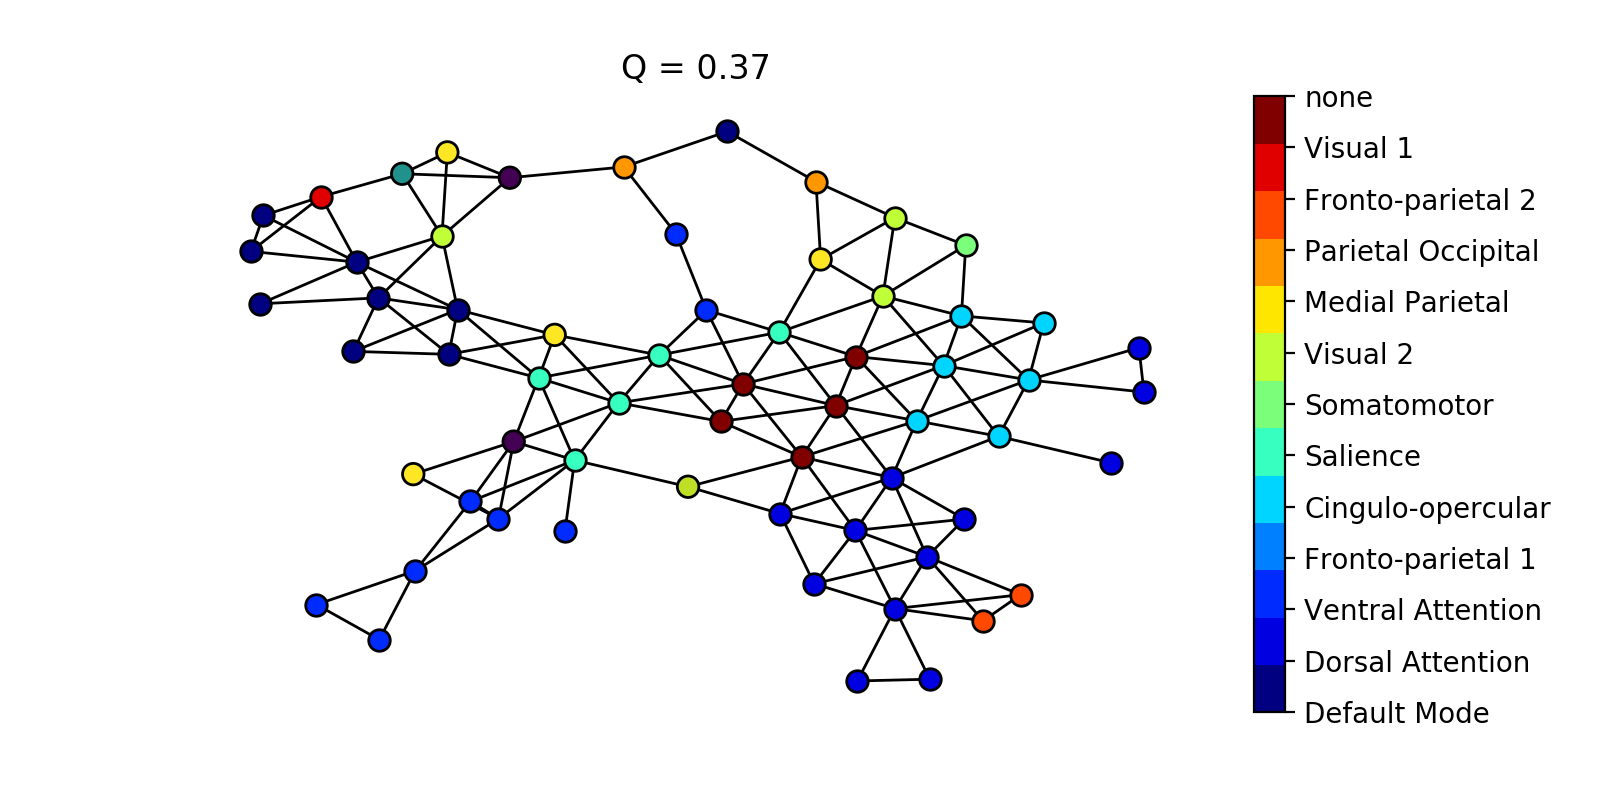

In [31]:
# Generate colormap
cmap = plt.get_cmap('jet',13)
colordict = {'Default Mode' : 0,
                 'Dorsal Attention' : 1,
                 'Ventral Attention' : 2,
                 'Fronto-parietal 1' : 3,
                 'Cingulo-opercular' : 4,
                 'Salience' : 5,
                 'Somatomotor' : 6,
                 'Visual 2' : 7,
                 'Medial Parietal' : 8,
                 'Parietal Occipital' : 9,
                 'Fronto-parietal 2' : 10,
                 'Visual 1' : 11,
                 'none' : 12}

Qs = []
plt.close('all')
fig,ax = plt.subplots(nrows=1,figsize=(8,4))
for i,G in enumerate(Ggiants):
    if i != 3: continue
#     # Get subject id
#     subid = sessions[i].y[0][1][:-4]
#     # Get day of week - Tuesday is fasted, Thursday is fed
#     try:
#         day = int(df_behavior[df_behavior['subcode'] == subid]['day_of_week'])
#     except ValueError:
#         continue
#     if day == 2:
#         state = 'fed'
#     elif day == 4:
#         state = 'fasted'
#     else:
#         continue
    partition = dict()
    # Get proportions
    props = nx.get_node_attributes(G,'proportions')
    # Iterate through each node and get most common network activation
    for p in props.keys():
        # Pull out the dicts for each network - result will be a list of lists of dicts (jesus christ)
        nws = list(props[p].values())[:-2]
        # Pull out the values for network activations if group == 1, else it's a 0
        nwtotals = [dic['value'] if dic['group'] == 1 else 0 if len(dictlist) == 1 else -1 for dictlist in nws for dic in dictlist]
        # Remove the -1s
        nwtotals = [el for el in nwtotals if el != -1]
        # Get indices of max values
        highestnws = np.argwhere(nwtotals == np.max(nwtotals))[0]
        # Randomly choose the highest network
        nwlabel = np.random.choice(np.array(list(props[p].keys()))[highestnws])
    
        partition[p] = nwlabel
        
    Q = community.modularity(partition,G)
    Qs.append(Q)
    
    
    size = len(set(partition.values()))
    

    pos = nx.kamada_kawai_layout(G)
    for com in set(partition.values()) :
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 60, node_color = cmap(colordict[com]), edgecolors = 'k',ax=ax)

    nx.draw_networkx_edges(G, pos, alpha=1.0, ax=ax)
    ax.axis('off')

    # Create text box
    ax.set_title('Q = %.2f' % Q)
    norm = mpl.colors.Normalize(vmin=0,vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=np.linspace(0,1,13), ax = ax)
    cbar.ax.set_yticklabels(rsns)

plt.savefig('RSN_modularity.png', dpi=300)
plt.show()


Number of communities: 22


<IPython.core.display.Javascript object>


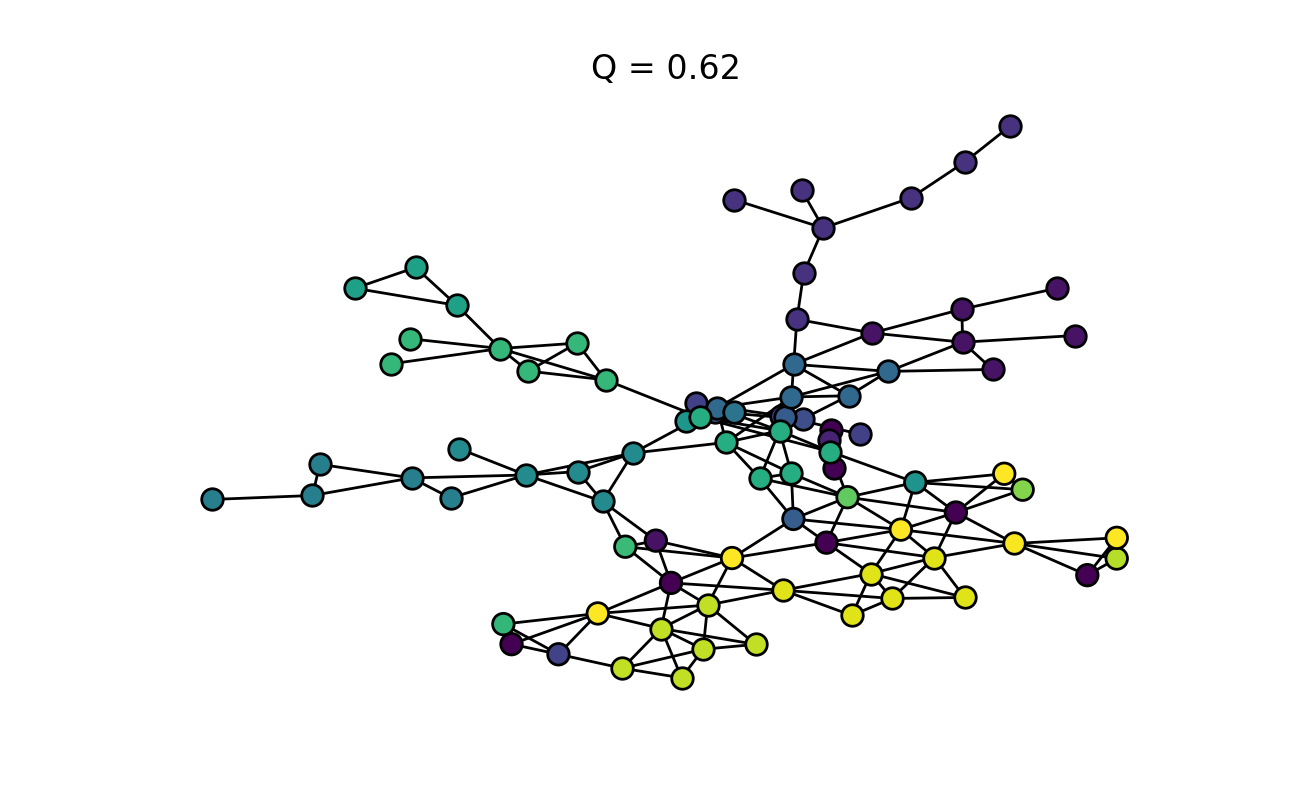

In [63]:
# What is the optimal community structure?
plt.close('all')
partition2 = community.best_partition(G,resolution=0.28)
size = len(set(partition2.values()))
print('Number of communities: %d' % size)
# Generate colormap
colors = plt.cm.viridis(np.linspace(0,1,size))

pos = nx.kamada_kawai_layout(G)
for com in set(partition2.values()) :
    list_nodes = [nodes for nodes in partition2.keys() if partition2[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 60, node_color = colors[com], edgecolors = 'k')

nx.draw_networkx_edges(G, pos, alpha=1.0)
ax = plt.gca()
ax.axis('off')

# Create text box
Q = community.modularity(partition2,G)
ax.set_title('Q = %.2f' % Q)

fig = plt.gcf()
fig.set_size_inches(6.5,4)
plt.show()
    

In [33]:
from sklearn.metrics import adjusted_rand_score
# How do the community structures compare?
commA = []
commB = []
for node in list(partition.keys()):
    commA.append(partition[node])
    commB.append(partition2[node])
ari = adjusted_rand_score(commA,commB)
print('Rand index: %.3f' % ari)

Rand index: 0.276


### Other measures

#### Degree distribution

<IPython.core.display.Javascript object>


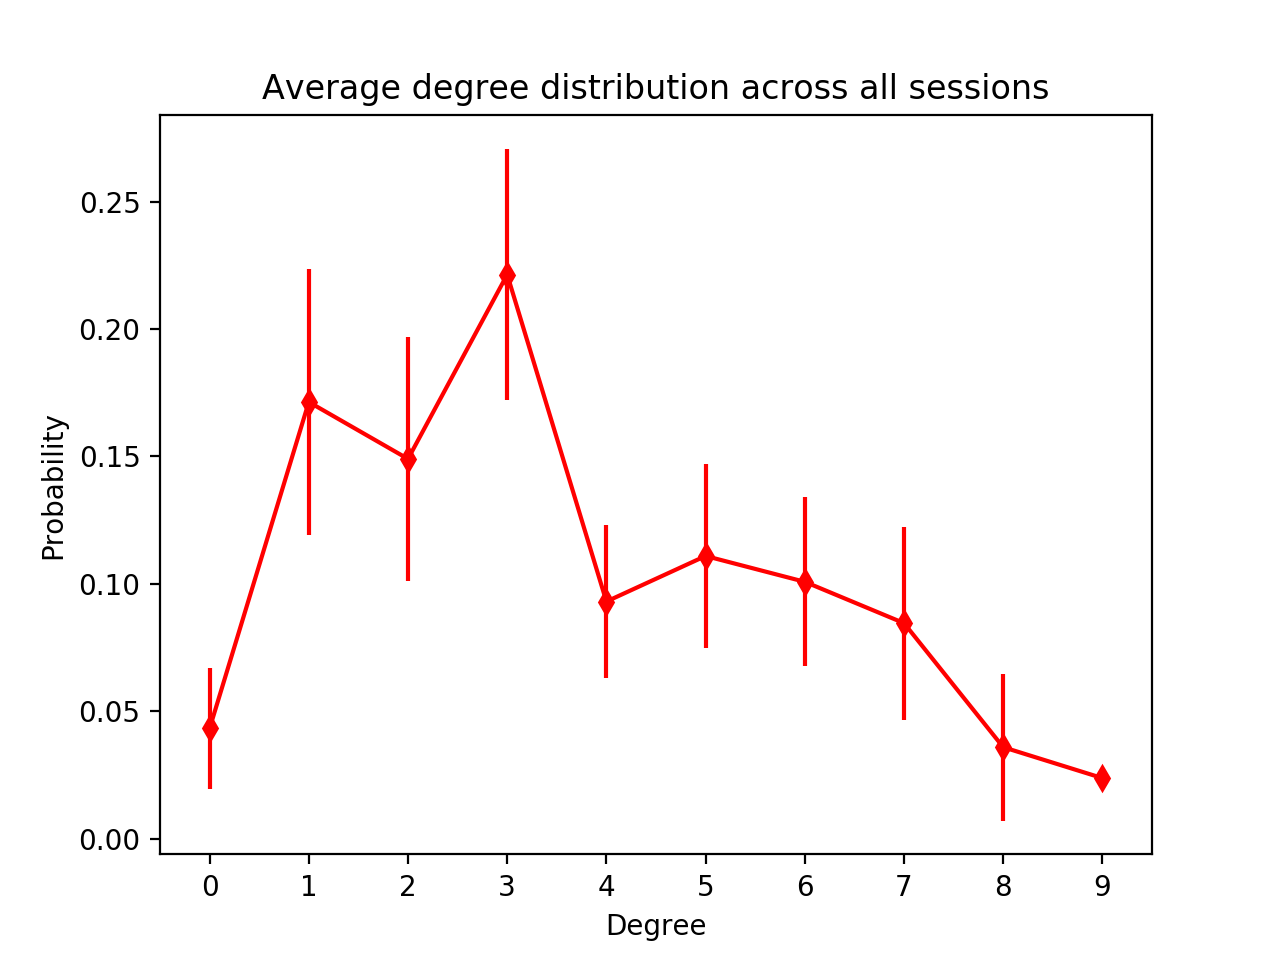

In [61]:
import collections

alldeg = collections.defaultdict(list)
for G in Gs: 
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    # Convert to probabilities
    total_cnt = float(sum(cnt))
    p = [el / total_cnt for el in cnt]
    for ind,d in enumerate(deg):
        alldeg[d].append(p[ind])

# Calculate mean probabilities and std
pmean = [np.mean(alldeg[d]) for d in sorted(alldeg.keys())]
pstd = [np.std(alldeg[d]) for d in sorted(alldeg.keys())]

# Plot distribution
plt.close('all')
plt.xlim([min(sorted(alldeg.keys()))-0.5,max(sorted(alldeg.keys()))+0.5])
plt.xticks(np.linspace(min(sorted(alldeg.keys())),max(sorted(alldeg.keys())),len(list(alldeg.keys()))))
plt.errorbar(sorted(alldeg.keys()), pmean, yerr=pstd, color='r', fmt='-d')
plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title('Average degree distribution across all sessions')
plt.show()

In [237]:
sleep = np.array(df_behavior['morning:Sleepquality'].tolist())
sleep[sleep == '.'] = 3
sleep = sleep.astype(int)

In [238]:
from scipy.stats import pearsonr
r,p = pearsonr(sleep,Qs)
print(r)
print(p)

0.014350761374199172
0.8969123615780031


<IPython.core.display.Javascript object>


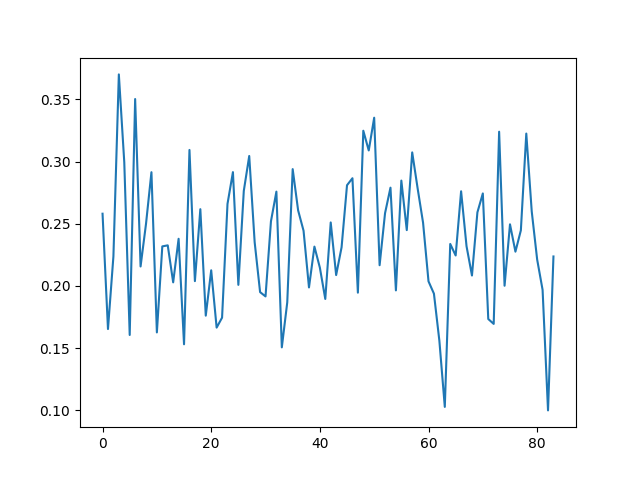

In [225]:
plt.close('all')
plt.plot(Qs)
plt.show()

### Import behavioral data

In [ ]:
df_behavior = pd.read_table('data/base/behavior/trackingdata_goodscans.txt')

What if we compared Mappers between scans with good and bad sleep quality?

In [24]:
df['morning:Sleepquality'] = pd.to_numeric(df['morning:Sleepquality'],errors='coerce')
df[df['morning:Sleepquality'] > 4]

,subcode,date,afterscan:Anxietyduringscan,afterscan:diastolic,afterscan:pulse,afterscan:systolic,blood:ba,blood:eo,blood:hgb,blood:ly,...,scan:noisecancel,weather:precip,weather:temphi,weather:templo,weight,zeo:timeInDeep,zeo:timeInLight,zeo:timeInRem,zeo:totalZ,zeo:zq
67,sub086,2013-10-22,5,75,68,109,.,.,.,.,...,1,0.0,77,54,149.78,.,.,.,.,.
69,sub088,2013-10-29,5,73,70,127,.,.,.,.,...,1,0.0,84,71,151.00,144.5,198.0,149.5,492.0,108


In [27]:
df[df['morning:Sleepquality'] <= 1]

,subcode,date,afterscan:Anxietyduringscan,afterscan:diastolic,afterscan:pulse,afterscan:systolic,blood:ba,blood:eo,blood:hgb,blood:ly,...,scan:noisecancel,weather:precip,weather:temphi,weather:templo,weight,zeo:timeInDeep,zeo:timeInLight,zeo:timeInRem,zeo:totalZ,zeo:zq
12,sub026,2012-11-27,3,79,82,136,0.0,0.2,14.0,1.5,...,1,0.00,60,40,147.53,137,147,106,389,88
25,sub042,2013-01-29,5,77,68,119,.,.,.,.,...,0,0.01,84,57,148.65,78,211,92,380,72
63,sub082,2013-10-03,5,76,73,115,.,.,.,.,...,1,0.00,93,76,151.43,128.5,213.5,134.0,476.0,103
70,sub089,2013-10-31,6,76,81,122,.,.,.,.,...,1,1.43,82,54,150.06,81.5,237.0,121.5,440.0,86


In [34]:
print(df.columns)

subcode                                              sub088
date                                             2013-10-29
afterscan:Anxietyduringscan                               5
afterscan:diastolic                                      73
afterscan:pulse                                          70
afterscan:systolic                                      127
blood:ba                                                  .
blood:eo                                                  .
blood:hgb                                                 .
blood:ly                                                  .
blood:mch                                                 .
blood:mchc                                                .
blood:mcv                                                 .
blood:mo                                                  .
blood:mpv                                                 .
blood:ne                                                  .
blood:plt                               

In [35]:
print(df.iloc[70,:].to_string())

subcode                                              sub089
date                                             2013-10-31
afterscan:Anxietyduringscan                               6
afterscan:diastolic                                      76
afterscan:pulse                                          81
afterscan:systolic                                      122
blood:ba                                                  .
blood:eo                                                  .
blood:hgb                                                 .
blood:ly                                                  .
blood:mch                                                 .
blood:mchc                                                .
blood:mcv                                                 .
blood:mo                                                  .
blood:mpv                                                 .
blood:ne                                                  .
blood:plt                               

In [71]:
from collections import Counter
meta = np.array([[0,1],[1],[0,2],[2],[1],[0,3]])
groups = list(meta)
if type(groups[0]) is list:
    A = [el for sublist in groups for el in sublist]
meta

array([list([0, 1]), list([1]), list([0, 2]), list([2]), list([1]),
       list([0, 3])], dtype=object)

In [77]:
type(meta[0]) is list

True